In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc3 as pm


from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
az.style.use('arviz-whitegrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Modelado probabilístico, si es Bayes es bueno</h1> 
<h2 align="center">Intro to Probabilistic programming</h2> 
    


<br>
<br>
<br>
<br>
<br>
<h4 align="center">
Buenos Aires, junio 2019
</h4> 

## Aims

* Learn to build simple models with PyMC3
* Introduction to ArviZ
* Compare groups in terms of effect size (as opposite to "statistical significance")

# Probabilistic programming


* Although conceptually simple, fully probabilistic models often lead to analytically intractable expressions

* Probabilistic programs are _regular_ programs with two added constructs:
    * The ability to draw values at random from distributions
    * The ability to condition values of variables in a program via observations.

* The _promise of probabilistic programming_  is clear separation of modeling and inference. Practitioners should focus on modeling, not _computational/mathematical details_

* Models are written in code and then _compiled_ to get the posterior

* _Universal inference engines_ can solve any probabilistic model (over-statement!)

In [5]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # en una situación real este valor es desconocido
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)
datos

array([1, 0, 0, 0])

In [6]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1, beta=1)  # a priori
    y = pm.Bernoulli('y', p=θ, observed=datos)  # likelihood
    trace = pm.sample(1000)  # Universal Inferece engine! 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2056.60draws/s]


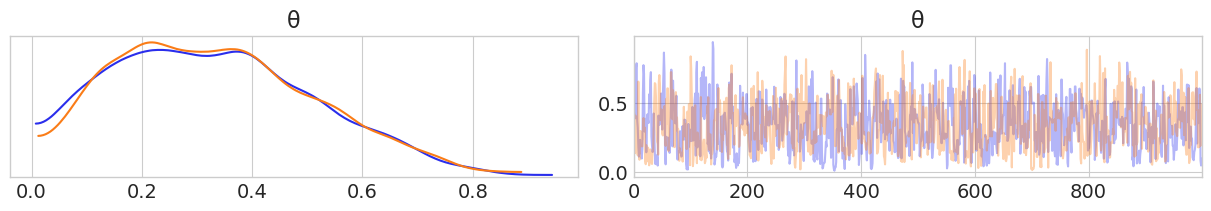

In [7]:
az.plot_trace(trace);

In [8]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
θ  0.337342  0.180195  0.006093  0.027517  0.672378  821.902657  0.999653

## Gaussian-model or inferring the speed of light

At the end of the 19th century Simon Newcomb conducted several experiments to determine the speed of light. In one of them, Newcomb measured the time it took for the light to travel 7,442 meters.

In [9]:
datos = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

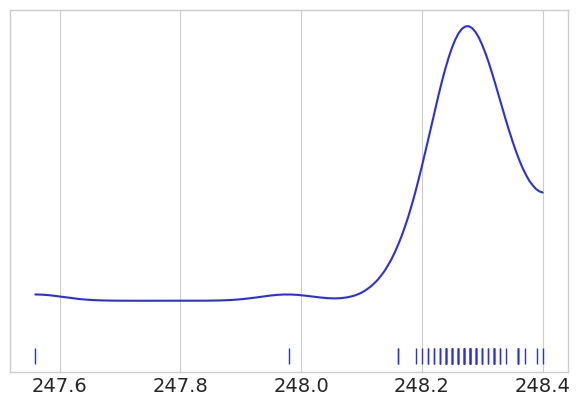

In [10]:
az.plot_kde(datos, rug=True)
plt.yticks([]);




\begin{align} 
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y &\sim \mathcal{N}(\mu, \sigma)
\end{align}

In [11]:
with pm.Model() as modelo_g:
    # Priors
    μ = pm.Uniform('μ', 240, 250)
    #μ = pm.Normal('μ', 240, 100) # alternative prior
    σ = pm.HalfNormal('σ', sd=1)
    #σ = pm.HalfNormal('σ', sd=datos.std() * 100)
    # Likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=datos)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2336.63draws/s]


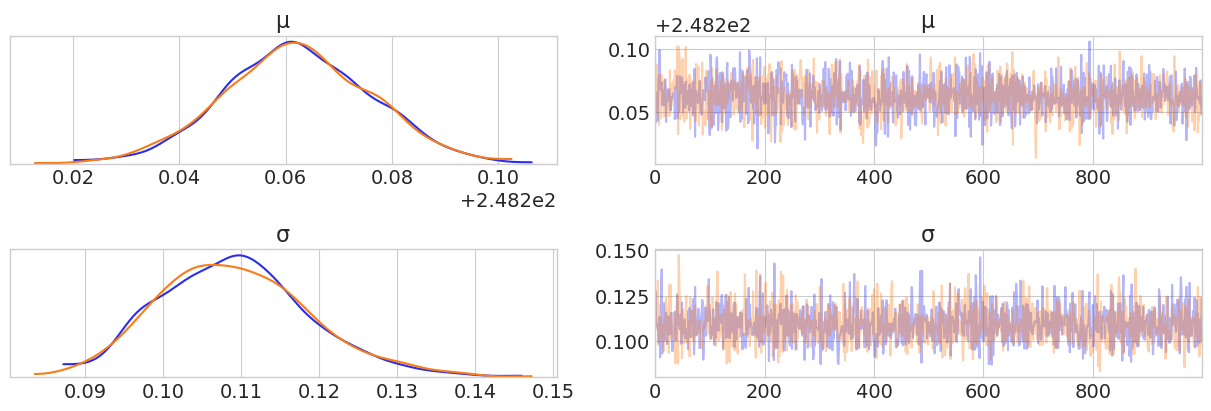

In [12]:
az.plot_trace(trace_g);

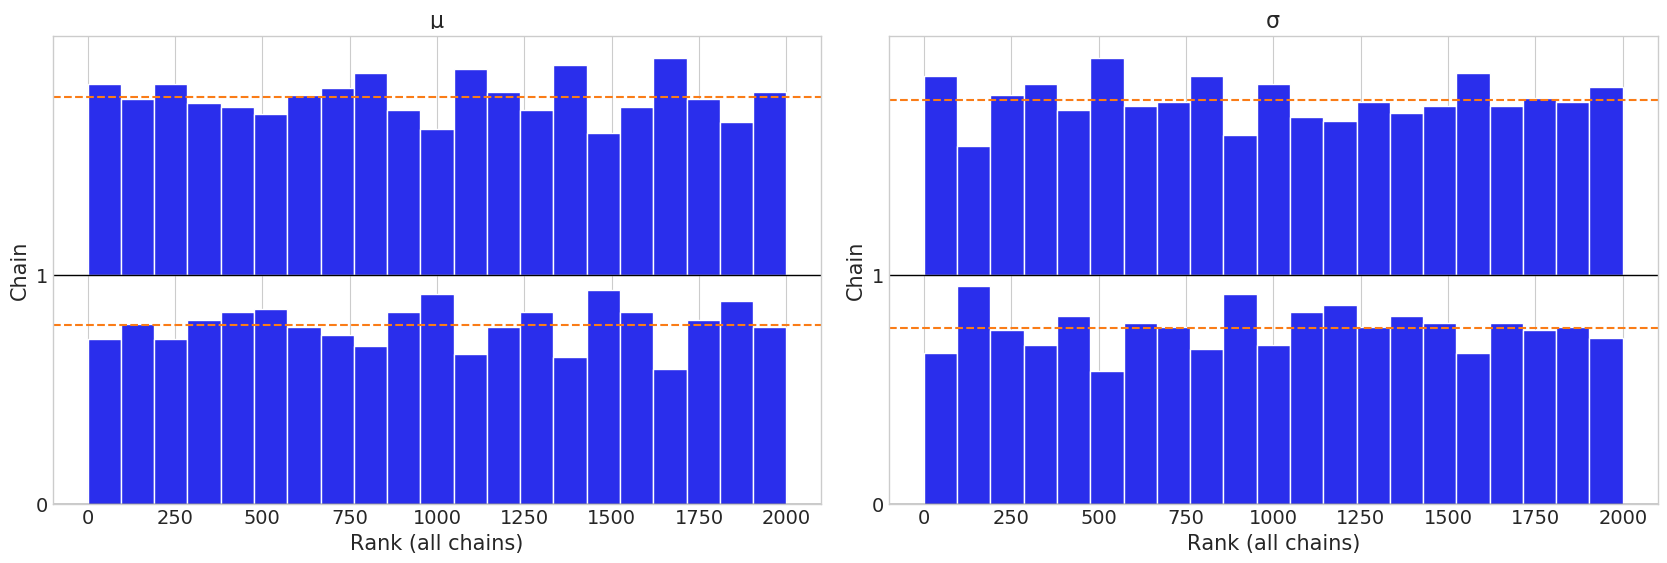

In [13]:
az.plot_rank(trace_g);

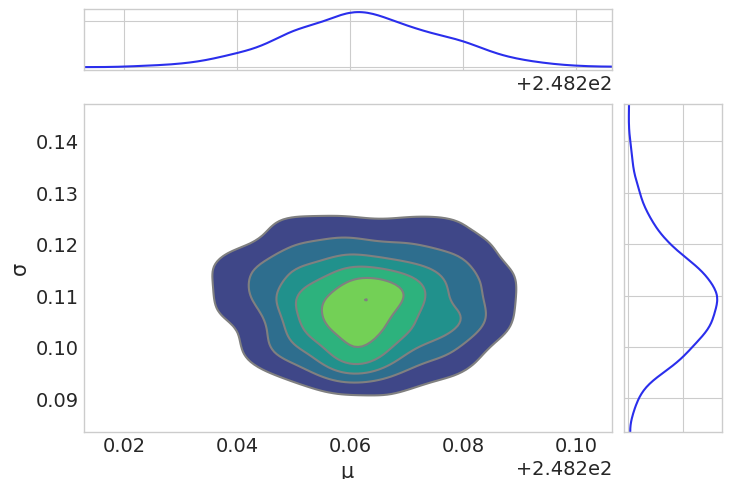

In [14]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

## Posterior predictive distribution

**Conceptually**: The distribution of _predicted data_ ($\tilde{y}$) according to the _posterior_ (i.e the logical consequence of model and observed data)


**Mathematically**
\begin{equation}
p(\tilde{y} \,|\, y) = \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta
\end{equation}


* $y$ --> observed data
* $\theta$  --> model's parameters


**computationally**

Following the speed of light example:

1. Pick an $i$ element from PyMC3's `trace` $\theta_i = (\mu_i, \sigma_i)$
2. Generate a random value from the distribution used as _likelihood_ with parameters $\theta_i$ --> $\tilde{y_i}  \sim N(\mu_i, \sigma_i)$
3. Repeat 1 and 2 $N$ times


In [15]:
ppc_g = pm.sample_posterior_predictive(trace_g, 100, modelo_g)

100%|██████████| 100/100 [00:00<00:00, 1329.49it/s]


## Posterior predictive checks

* Simulated data can be used to make predictions
* Simulated data can be used to check models predictions (criticize the model)

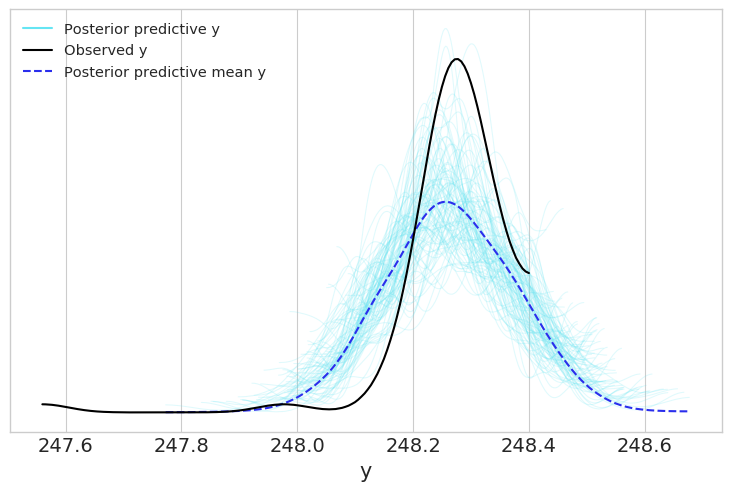

In [16]:
datos_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=ppc_g)
az.plot_ppc(datos_ppc);

<center>
<img src="img/bayesian_workflow.png" width=700>
</center>

[Mathematical Theory of Bayesian Statistics](https://www.crcpress.com/Mathematical-Foundations-of-Bayesian-Statistics/Watanabe/p/book/9781482238068)

In [17]:
#Modelos Robustos. ejercicio

### Coal mining disasters

<br>

* We have a record of the number of accidents in coal mines, located in the United Kingdom, that occurred between 1851 and 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)).

* We want to study the effect of safety regulations in the decrease in the number of accidents. We are interested in finding out the year in which the rate changed also in estimating both rates.

* Some data is missing 

<br>
<br>

From [PyMC3 docs](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)

In [18]:
accidents = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                                  3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                  2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                                  1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                  0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                                  3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                  0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

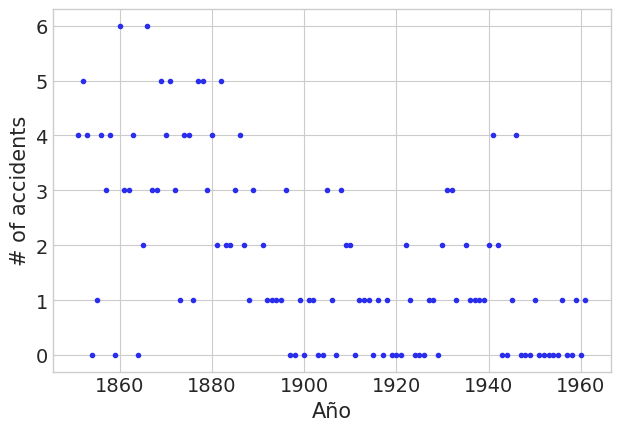

In [19]:
plt.plot(years, accidents, '.')
plt.ylabel("# of accidents")
plt.xlabel("Año");

<img src="img/modelo_mineros.png" width=350>

\begin{equation}
y \sim Poisson(rate)
\end{equation}

\begin{equation}
rate = \begin{cases}
t_0, \text{if } t \ge cp,\\
t_1, \text{if } t \lt cp
\end{cases}
\end{equation}

\begin{align}
t_0 \sim Exp(\lambda) \\
t_1 \sim Exp(\lambda) \\
cp \sim U(L, H)
\end{align}


In [20]:
with pm.Model() as model_cat:

    cp = pm.DiscreteUniform('cp', lower=years.min(), upper=years.max())
    t_0 = pm.Exponential('t_0', 1/10)
    t_1 = pm.Exponential('t_1', 1/10)
    
    rate = pm.math.switch(cp >= years, t_0, t_1)

    acc = pm.Poisson('acc', rate, observed=accidents)
    trace_cat = pm.sample(5000)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/model.py:1330: UserWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [acc_missing]
>>Metropolis: [cp]
>NUTS: [t_1, t_0]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:07<00:00, 1398.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


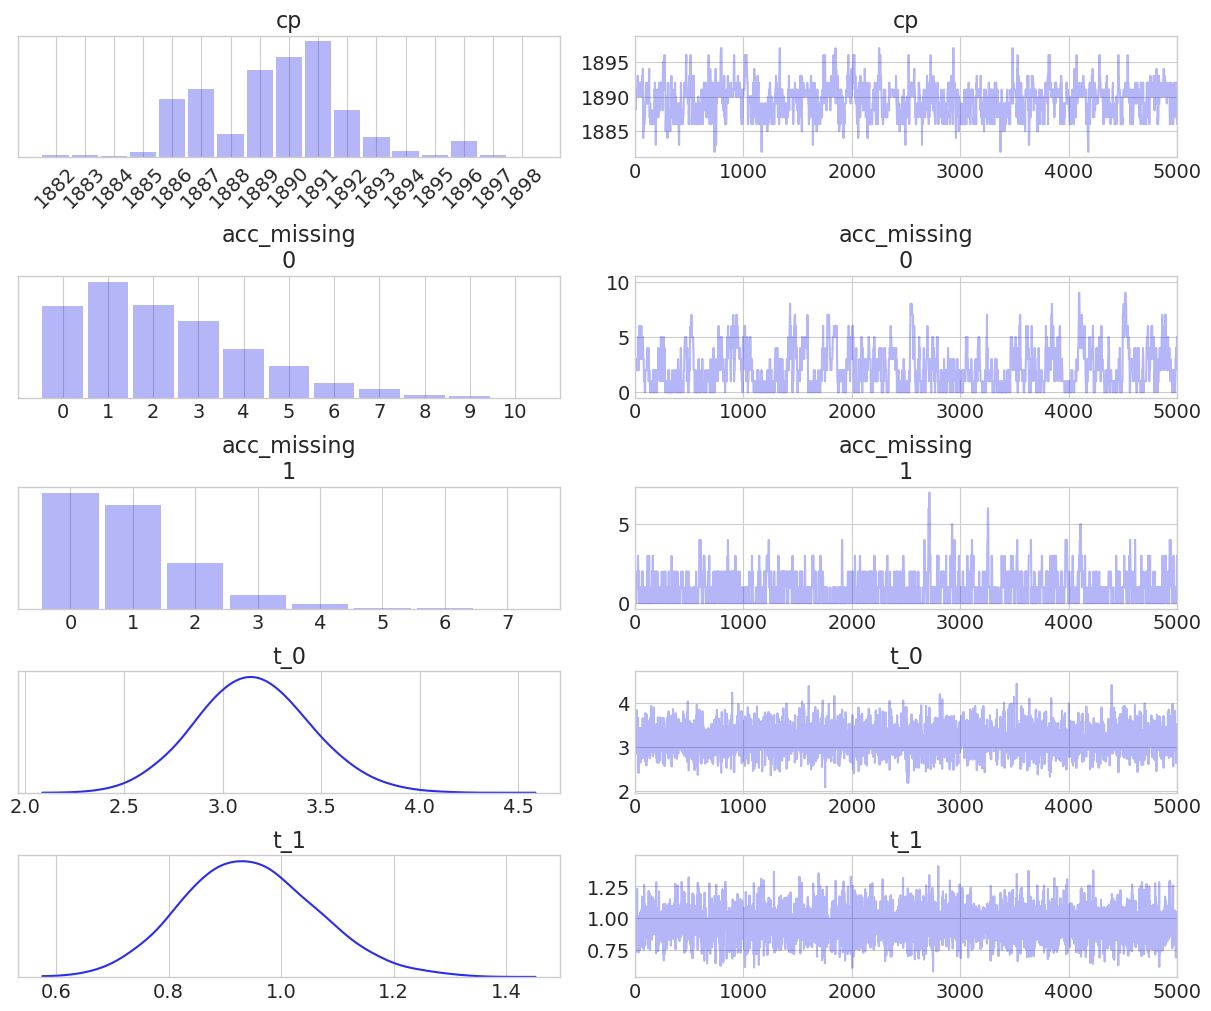

In [21]:
ax = az.plot_trace(trace_cat, combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];

In [22]:
pm.summary(trace_cat)

mean        sd  mc_error      hpd_2.5     hpd_97.5  \
cp              1889.611300  2.480083  0.096348  1885.000000  1894.000000   
acc_missing__0     2.204900  1.837312  0.091130     0.000000     6.000000   
acc_missing__1     0.911700  0.986865  0.027098     0.000000     3.000000   
t_0                3.159398  0.289984  0.003705     2.609759     3.741390   
t_1                0.945976  0.119269  0.001634     0.718155     1.181029   

                      n_eff      Rhat  
cp               556.426854  1.002889  
acc_missing__0   296.549549  0.999935  
acc_missing__1  1062.852627  1.000009  
t_0             5255.715972  1.000938  
t_1             5437.001407  1.000006

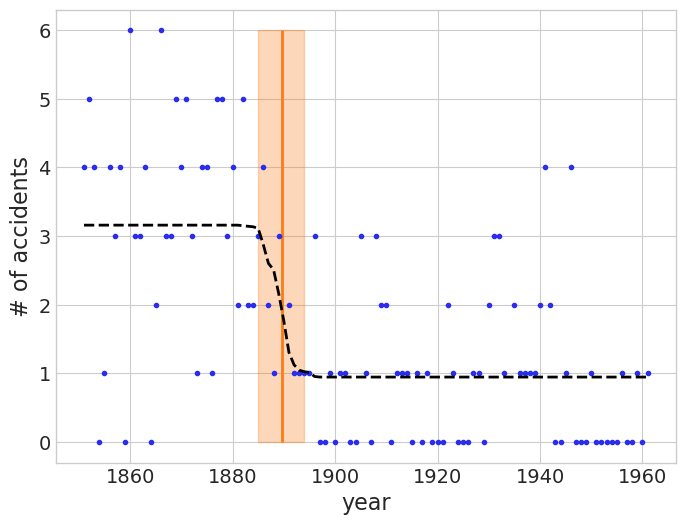

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(years, accidents, '.')
plt.ylabel("# of accidents", fontsize=16)
plt.xlabel("year", fontsize=16)

plt.vlines(trace_cat['cp'].mean(), accidents.min(), accidents.max(), color='C1', lw=2)
accidents_ave = np.zeros_like(accidents, dtype='float')
for i, year in enumerate(years):
    idx = year < trace_cat['cp']
    accidents_ave[i] = ((trace_cat['t_0'][idx].sum() + trace_cat['t_1'][~idx].sum()) 
                              / (len(trace_cat) * trace_cat.nchains))

pc_hpd = pm.hpd(trace_cat['cp'])
plt.fill_betweenx([accidents.min(), accidents.max()], pc_hpd[0], pc_hpd[1], alpha=0.3, color='C1');
plt.plot(years, accidents_ave,  'k--', lw=2);

## Group comparison

* One common statistical inference problem is the comparison of two (or more) groups
* We may be interested in whether one group is larger than another, or simply different from the other
* We require a statistical model for this because true differences are usually accompanied by measurement or stochastic noise that prevent us from drawing conclusions simply from differences calculated from the observed data.

####  The tips data-set

* We want to study how the day of the week affects the amount of tip at a given restaurant


[Bryant, P. G. and Smith, M](https://www.amazon.com/Practical-Data-Analysis-Peter-Bryant/dp/0256238715/ref=dp_ob_title_bk)

In [25]:
tips = pd.read_csv('../datos/propinas.csv')
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

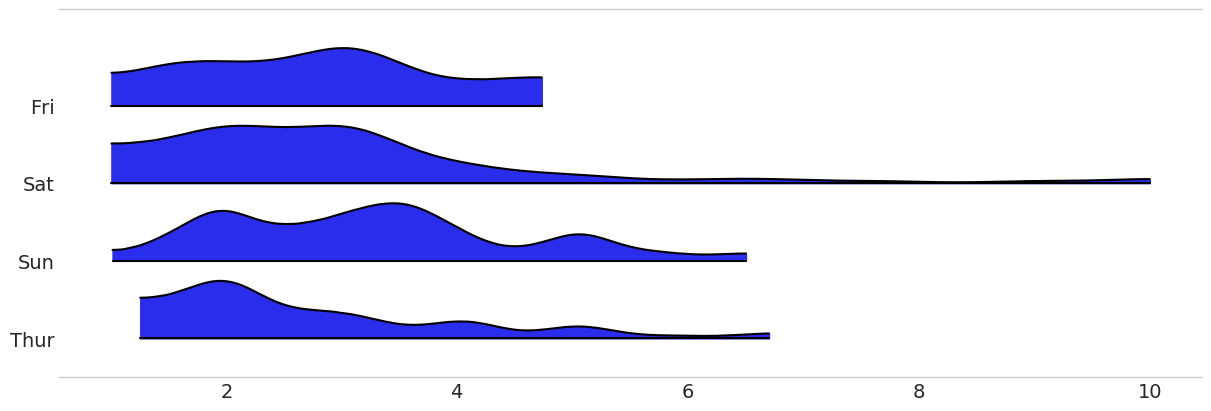

In [26]:
# Using arviz to plot data, not a posterior ¯\_(ツ)_/¯
az.plot_forest(tips.pivot(columns='day', values='tip').to_dict('list'),
               kind='ridgeplot',
               figsize=(12, 4));

In [27]:
categories = ['Thur', 'Fri', 'Sat', 'Sun']

tip = tips['tip'].values  # tips in dollars
idx = pd.Categorical(
    tips['day'],
    categories=categories).codes  # dummy variable ['Thur', 'Fri', 'Sat', 'Sun'] --> [0, 1, 2, 3]
groups = len(np.unique(idx))

In [28]:
with pm.Model() as comparing_groups:
    #  μ and σ are now vectors of shape "groups"
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)  
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)  # we use idx to properly index μ and σ

    trace_cg = pm.sample(5000)
#az.plot_trace(trace_cg);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:15<00:00, 715.41draws/s]


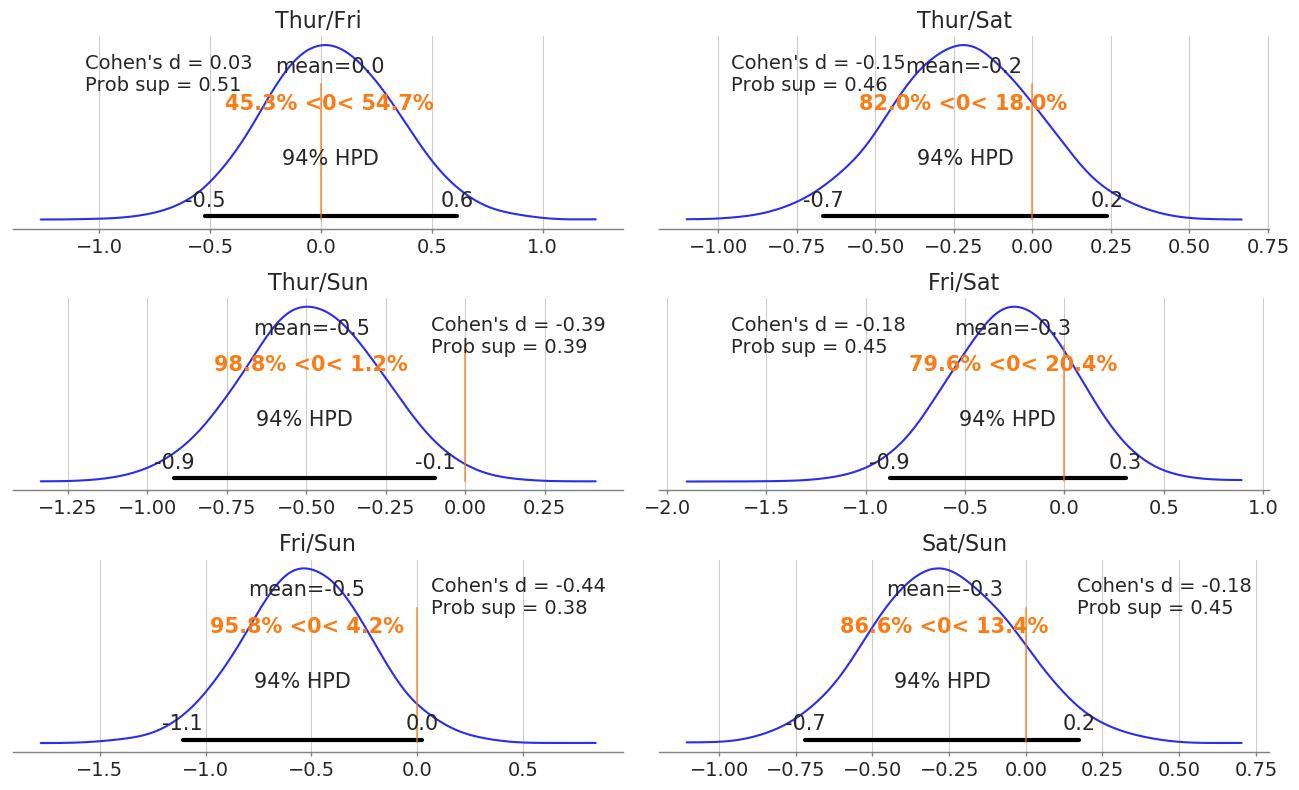

In [29]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(13, 8))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:,i] - trace_cg['μ'][:,j]
    d_cohen = (means_diff / ((trace_cg['σ'][:,i]**2 + trace_cg['σ'][:,j]**2) / 2)**0.5).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title("%s/%s" % (categories[i], categories[j]))
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l ].legend(fontsize=14)
plt.tight_layout()

### Effect size


**Cohen's d**

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}
$$


* Can be interpreted as a z-score. How many (pooled) standard deviation a mean of one group is above (or below) the mean of the other group
* Check this interactive [examples](http://rpsychologist.com/d3/cohend)

**Probability of superiority**


* The probability that a data-point from one group is larger than a data-point from the other. 
* If we assume the data is normally distributed then:

\begin{equation} \label{eq_ps}
ps = \Phi \left ( \frac{\delta}{\sqrt{2}} \right)
\end{equation}


$\Phi$ is the cdf of the normal distribution and $\delta$ is Cohen's d.

## Exercies